\begin{titlepage}

% Photo of FS
\centering
\vspace{-40pt}
\includegraphics[width=0.8\textwidth]{Frankfurt_School_Logo.jpg}\par
\vspace{2.5cm}

% Course
{\scshape\huge Assignment 1 \par}
\vspace{2.5cm}

% Title
{\Huge\bfseries Covic-19 Disasters \par}
{\scshape\large Studying the SIRD Model \par}

\vspace{2cm} % If signature is taken might have to add space.


{\Large Yannik Suhre \par}
{\Large Skyler MacGowan \par}
{\Large Debasmita Dutta \par}
{\Large Sebastian Sydow \par}
\vspace{0.5cm}

% Date
\vfill
{\large \today\par}
\end{titlepage}


\newpage

\hypersetup{linkcolor=black}
\tableofcontents

\newpage

# Introduction
\label{section:Introduction}

The following document provides our solutions for the given exercises. 

# Question 1

This code is based on prior work conducted by Jan Nagler; the modications made were effectuated in order to solve the following exercise problems:

* **a**. Derive the corresponding system of equations for S, I, R and D. E.g., $\frac{dD}{dt} = \mu I$ but this is not the only difference to SIR. In addition, the basic
reproduction number may now depend on µ as well, how? 

* **b**. Assume that the basic reproduction number $R_0$ for B.1.1.7 is not exactly known but only the range $R_0 \in [3.0; 4.0]$. Assume that the mortality rate µ is also not exactly known but only the range $\mu \in [0.4\%; 4\%]$. Study how these parameter uncertainties affect the prediction of D at t = 365d.

* **c**. Study numerically the effects of a hard versus soft lockdown (by two for you reasonable values of β), in terms of D(365d). Assume µ = 1% and a γ compatible with $R_0$ = 4. 

We will start by importing some packages that can be leveraged when solving the exercise problems.

In [1]:
#### Imports ####
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, PercentFormatter
from matplotlib import cm
from IPython.display import display, Markdown
from mpl_toolkits.mplot3d import Axes3D

# set matplotlib to inline
%matplotlib inline

## Class Explanation
\label{section:Class_explanation}

In order to incorporate all the different things, and to do this with as less code as possible, we will define a class. Which methods this class contains and how the different methods work, will be displayed here.

<div class="alert alert-block alert-info">
<b>Note:</b> Bear in mind, that the following section will outline the docstrings for the different methods. Thus, these docstrings will <b>not</b> be displayed in the code when creating the class itself.
</div>

### Class creation
\label{section:class_creation}

The overall class is called ```SIRD``` in order to make explicit what this function is used for. It is defined like
```python
class SIRD():
   """This class alters the SIR model from Epidemiology in order
   to incorporate the deaths caused by the desease"""
```

Classes contain different methods and attributes. A method is defined within the class context as a normal function, using the ```def ...``` notation. Be aware, that since that method is defined **within** the class, it is only accessable through the class, meaning we have to use the class object in order to execute it.

In order to give a class its attributes we can make use of the ```self```. Using this name we can create and update parameters which belong to the class (*how this is done exactly will be shown later*). In order to have a clear overview, of how to create a class and which parameters to give it, let us explain the double underscore (*dunder*) function ```__init__()```. This is the function, which will be called, when the object is instantiaded (*E.g. ```SIRD()```; the ```()``` means instantiaded in this context*).

```Python
def __init__(self, N: int, I0: float, R0: float, D0: float, beta: float,
                 gamma: float, mu: float, recovery_in_days: int,  days: int):
    """This functions adds the given parameters to the object, which
    is instantiated using the SIRD class.
    
    Within this class, we also calculate R_nought, the basic reproduction
    number R_0 (pronounced R-nought) which is the average number of cases
    directly generated by one case in a population where all individuals
    are susceptible to infection using the formula
    R_nought = beta / (gamma + mu) and we calculate S0, which displays
    the number of susceptible persons, using the formula 
    S0 = S0 = N - I0 - R0 - D0.

    Parameters
    ----------
    N : int
        Represents the populations size, if you set it to 1,
        the model will ignore N and it will return fractions
    I0 : float
        The total number of infected people at time zero
    R0 : float
        The total number of recovered people at time zero
    D0 : float
        The total number of death at the time zero
    beta : float
        The contact rate, more specifically how many people
        does one infected infects
    gamma : float
        The recovery rate, the rate of how fast infected people
        recover from the desease
    mu : float
        The mortality rate, the rate of how many of the infected
        people die
    recovery_in_days : int
        The days it takes to recover, this could also be
        calculated using 1/gamma, but was inserted here 
        for easier accessability
    days : int
        The timeframe, how long we will model the infectious disaster
    """
```

### Derivate function
\label{section:deriv}


Next we can set up the $SIR(D)$ model. For the most part this is the function developed by Jan Nagler, albeit with some modifications that allow us to incorperate the mortility rate $\mu$.

```python
def _deriv(self, y, t, N, beta, gamma, mu):
    """Altered function of the SIR model,
    in order to incorporate the deaths,
    mu.

    Parameters
    ----------
    y : ndarray
        This array contains the initial models
    t : np.array
        A np.array created using np.linespace in
        order to model the time
    N : int
        The population size or 1
    beta : float
        The contact rate, more specifically how many people
        does one infected infects
    gamma : float
        The recovery rate, the rate of how fast infected people
        recover from the desease
    mu : float
        The mortality rate, the rate of how many of the infected
        people die
    """
```

### Effective reproduction number
\label{section:brn}


Yet another very important number when it comes to epidemiology is the **effective reproduction number**, which will be denoted by $R_{effective}$. The idea behind this number is that at any given time $t$ an unknown number of the susceptible population is immune to the disease, *or the average number of new infections caused by a single infected individual at time t in the partially susceptible population* [[3](https://en.wikipedia.org/wiki/Basic_reproduction_number#Effective_reproduction_number), [4](https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1a-epidemiology/epidemic-theory)]. As soon as this number drops below one, one can speak of *herd immunity*. Thus $R_e$ can be defined by $R_0 * \frac{susceptibles}{population}$.

For our model, we can calculate this using the following method.

```python
def _R_effective(self, subplot = False):
    """Calculates the effective reproduction number
    based on the formulae given by Jan Nagler.

    Parameters
    ----------
    subplot : bool, optional
        If true, it will return
        the time when the BRN reaches
        its maximum, by default False
    """
```

### Ordinary differential equation
\label{section:ode}


Now, we will make use of the ```odeint()``` function, which *integrates a system of ordinary differential equations* [[2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)]. The first argument for this function must be therefore a callable object, such as a function (e.g. *a callable object is everything which can be called using ```()```*). Its second argument is the vector with the initial conditions. Third, we have to specify the time variable; this was also done above ($t$) in the ```__init__()``` functon. In order to pass the function arguments to our given callable, we also need to specify the argument `args` with all the inputs the callable needs.

```python
def _ode(self):
    """Integrates different ordinary differential
    equations."""
```

### Calculate $\beta$ and $\gamma$
\label{section:beta_gamma}


In question 1.b the solution requieres us, to vary $R_{nought}$ and $\mu$. Since those two parameters are depended on $\gamma$ and $\beta$, we also have to recalculate those. Hence our class has a function for it.

```python
def _get_beta_gamma(self, R_nought, mu):
    """Returns beta and gamma based
    on recovery time and infectious power R
    
    Parameters
    ----------
    R_nought : float
        The basic reproduction number R_0
        (pronounced R-nought) which is the
        average number of cases directly
        generated by one case in a population
        where all individuals are susceptible
        to infection
    mu : float
        The mortality rate, the rate of how many of the infected
        people die
    """
```

### Plot $\mu$ and $R_{nought}$ w.r.t. cumulated deaths
\label{section:plot_mu_brn_wrt_cd}


Until now, we have just dealed with methods/functions which started with an underscore. Those are named *private* functions. These functions should **not** be used by anyone outside of the developer team. The usage for developing such *private* functions is, that those can then be used in the *public* functions of this class.

From here onwards, we will present our *public* functions. The first one is a function, which allows us to plot $\mu$ and $R_{nought}$ w.r.t. the cumulated deaths.

```python
def plot_mu_bn_wrt_cd(self, R_nought, mu, subplot = True):
    """This function makes use of the private functions,
    in order to calculate the fraction of deaths for
    question 1.b.
    
    Parameters
    ----------
    R_nought : float
        The basic reproduction number R_0
        (pronounced R-nought) which is the
        average number of cases directly
        generated by one case in a population
        where all individuals are susceptible
        to infection
    mu : float
        The mortality rate, the rate of how many of the infected
        people die
    subplot : bool, optional
        If true, it will return
        the time when the BRN reaches
        its maximum, by default False
    """
```

### Plot
\label{section:plot}


Lastly, in order to plot all of our things, we need to define a plotting function. This is done in the next step.

```python
def plot(self, subplot = False):
    """This functions uses as well
    all of the above defined private
    functions and then goes ahead and
    plots a graph, which visualizes
    the different functions.
    
    Parameters
    ----------
    subplot : bool, optional
        If true, it will return
        the time when the BRN reaches
        its maximum, by default False
```

## Class definition
\label{section:Class_def}

As shown above, a number of variables and functions are needed to solve the exercises problems. In the next cell, we will define a class that incorporates said variables/functions. The advantage of using a class is that we can easily change a given parameter and readily see/understand how doing so impacts the other parameters at play.

<div class="alert alert-block alert-info">
<b>Note:</b> Should any questions arise regarding the methods usage, please scroll up and review the respective docstrings.
</div>

In [2]:
class SIRD:

    def __init__(self, N: int, I0: float, R0: float, D0: float, beta: float,
                 gamma: float, mu: float, recovery_in_days: int,  days: int):
        self.N = N
        self.S0 = N - I0 - R0 - D0
        self.I0 = I0
        self.R0 = R0
        self.D0 = D0
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.R_nought = beta / (gamma + mu)
        self.recovery_in_days = recovery_in_days
        self.t = np.linspace(0, days, days)
    
    def _deriv(self, y, t, N, beta, gamma, mu):
        S, I, R, D = y
        # dSdt = - contact rate * the susceptibles * infected / total population
        # How many of the population is susceptible to the virus?
        dSdt = -beta * S * I / N
        # dIdt = contact rate * susceptibles * infected / total population - recovery rate * infected - 
        # mortality rate * infected
        # How many of the susceptibles will contract the virus?
        dIdt = beta * S * I / N - gamma * I - mu * I
        # dRdt = recovery rate * infected
        # How many of those that are infected recover excluded those that die?
        dRdt = gamma * I
        # dDdt = mortility rate * infected
        # How many of those that are infected will die?
        dDdt = mu * I
        return dSdt, dIdt, dRdt, dDdt
    
    def _R_effective(self, subplot = False):
        self.t_1 = 0
        for time in range(0,len(self.S)):
            if self.R_nought*self.S[time]/self.N < 1: 
                self.t_1 = time
                break
        if not subplot:
            display(Markdown(rf"$R_e$ = 1 after {self.t_1} days!"))
    
    def _ode(self):
        y0 = self.S0, self.I0, self.R0, self.D0
        ret = odeint(self._deriv, y0, self.t, args=(self.N, self.beta, self.gamma, self.mu))
        self.S, self.I, self.R, self.D = ret.T
        
    def _get_beta_gamma(self, R_nought, mu):
        self.gamma = 1./self.recovery_in_days
        self.beta = R_nought*(self.gamma + mu)
    
    def plot_mu_bn_wrt_cd(self, R_nought, mu, subplot = True):
        self._get_beta_gamma(R_nought, mu)
        self._ode()
        self._R_effective(subplot)
        self.fraction_deaths = self.D[-1]/self.N
        return self.fraction_deaths
        
    def plot(self, subplot = False):
        self._ode()
        self._R_effective(subplot)
        fig = plt.figure(facecolor='w', figsize = (16,8))
        ax = fig.add_subplot(111, axisbelow=True)
        ax.plot(self.t, self.S/self.N, alpha=0.5, lw=2, label='$S_{usceptible}$')
        ax.plot(self.t, self.I/self.N, alpha=0.5, lw=2, label='$I_{nfected}$')
        ax.plot(self.t, self.R/self.N, alpha=0.5, lw=2, label='$R_{ecovered}$')
        ax.plot(self.t, self.D/self.N, alpha=0.5, lw=2, label='$D_{eath}$')
        ax.plot(self.t, self.R_nought*self.S/self.N, alpha=0.5, lw=2, label='$R_{effective}$')
        ax.plot(self.t, np.full(len(self.t), self.R_nought), alpha=0.5, lw=2, label='$R_{nought}$')
        ax.set_xlabel('Time / days')
        ax.set_ylabel('Fraction')
        ax.set_ylim(0,2.2)
        ax.vlines(self.t_1, 0, 1, colors='k', linestyles='dashed')
        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax.legend(fontsize="large", loc = "upper right")
        legend.get_frame().set_alpha(0.5)
        
        plt.text(0.2, 0.75, f"The BRN is: {round(self.R_nought,2)}",
                     transform=ax.transAxes)
        plt.text(0.2, 0.4, f"D = t(365): {round(sum(self.D),2)}",
                     transform=ax.transAxes)
        
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)
        if subplot:
            x = list(map(lambda x: plt.gca().lines[x].get_xdata(), range(5)))
            y = list(map(lambda x: plt.gca().lines[x].get_ydata(), range(5)))
            lines, labels = ax.get_legend_handles_labels()
            plt.close()
            return x, y, lines, labels
        else:
            plt.show()

Now lets use this class, in order to instantiated it.

In [3]:
model = SIRD(N = 1, I0 = 0.2, R0 = 0, D0 = 0,
            beta = 0.39, gamma = 0.15, mu = 0.01,
            recovery_in_days = 14, days= 365)

### <h1><center>Question 1a</center></h1>

<b>Initial BRN Equation</b>

$R_0$=$\frac{\beta}{\gamma}$

The equation above is the initial way in which the the Basic Reproduction Number (BRN, as represented by $R_0$) was calculated. The BRN represents the average number of people one infected person will pass the virus on to. The two dependent variables are:<br>
- <i>Contact Rate ($\beta$)</i> - Describes the average number of close contacts per day of each individual in the population.
- <i>Recovery Rate ($\gamma$)</i> - Describes the daily rate at which each infected individual recovers from the virus. For example we used a $\gamma$ of 0.15, meaning we are expecting each infected individual in the population to take an average of 1/0.15 = 6.67 days to recover.



    
<b>BRN Equation after Incorporating the Mortality Rate</b>

One shortcoming of the Initial BRN Equation is that it groups all individuals who have had the virus and hence are no longer seen as being susceptible to the virus together through the recovery rate. This of course is not reflective of the reality, where a portion of the "previously infected and no longer susceptible" group would be those individuals who were killed by the virus. To capture this, the modified BRN equation below breaks down the recovery rate into two variables, a "true" recovery rate that indicates the average daily rate at which an infected individual recovers (meaning that he/she actually survives) as well as the virus's mortality rate, as represented by $\mu$. Below is the modified BRN equation.

$R_0$=$\frac{\beta}{\gamma+\mu}$

<u>Note</u>: Treating a cadaver as having no infectious potential may be erroneous, but considering how one might incorporate this the infectious potential of deceased individuals is beyond the scope of this assignment. Our model is also limited by the fact that the mortality rate does not account for natural deaths, assuming simply that all deaths were a result of the virus. <br> 

---

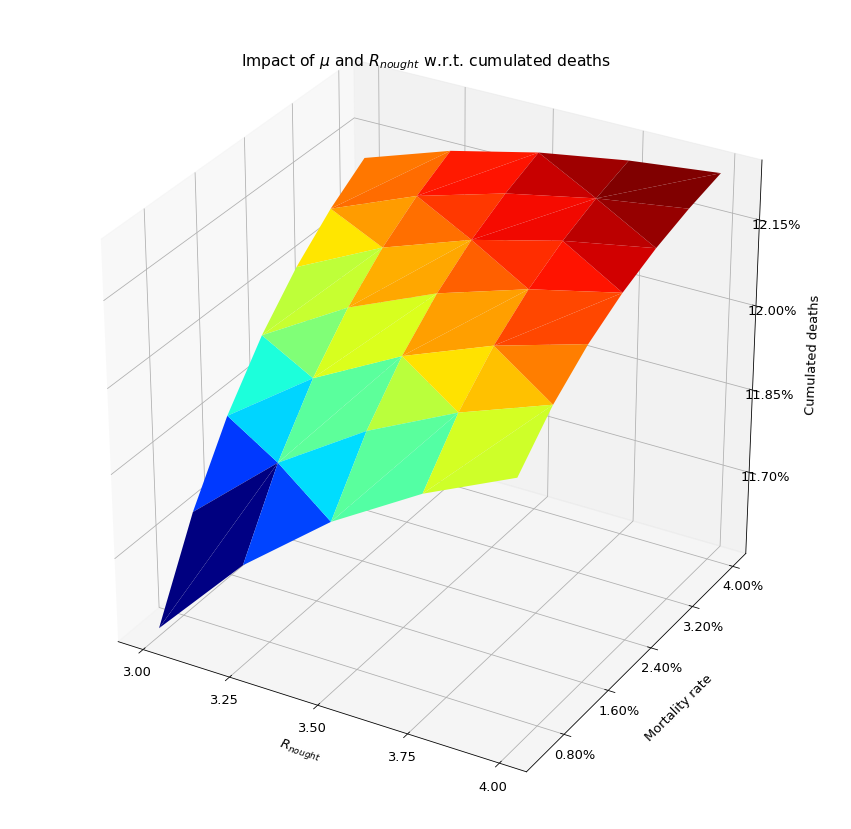

In [4]:
# range of r_nought:
r_nought = list(map(lambda x: x/100, range(300, 401, 25)))
    
# range of mortality rate:
mu = list(map(lambda x: x/1000, range(4, 41, 6)))

# create empty lists
r_nought_plot, mortalility_rate_plot, cum_deaths_plot = [], [], []

for i in r_nought:
    for j in mu:
        fraction_dead = model.plot_mu_bn_wrt_cd(i, j)
        
        r_nought_plot.append(i)
        mortalility_rate_plot.append(j)
        cum_deaths_plot.append(fraction_dead)

fig = plt.figure(figsize=(15, 15))
plt.rcParams['font.size'] = '13'
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(r_nought_plot,
                       mortalility_rate_plot,
                       cum_deaths_plot,
                       linewidth=0.5, cmap=cm.jet, antialiased=True)
ax.set_title("Impact of $\mu$ and $R_{nought}$ w.r.t. cumulated deaths")
ax.set_xlabel('$R_{nought}$', labelpad = 10)
ax.set_ylabel('Mortality rate', labelpad = 20)
ax.set_zlabel('Cumulated deaths', labelpad = 20)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax.zaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.zaxis.set_major_locator(MaxNLocator(5))
plt.show()

### <h1><center>Question 1b</center></h1>

The three-dimensional graph above shows the effect of different BRNs and mortality rates on cumulative deaths over a 365 day period. Specifically, the cumulative deaths are highest when both the mortality rate and the BRN have their highest values, respectively 4% and 4 days. Of these two variables, increases in the mortality rate have a more profound impact on the ensuing deaths.  <br>

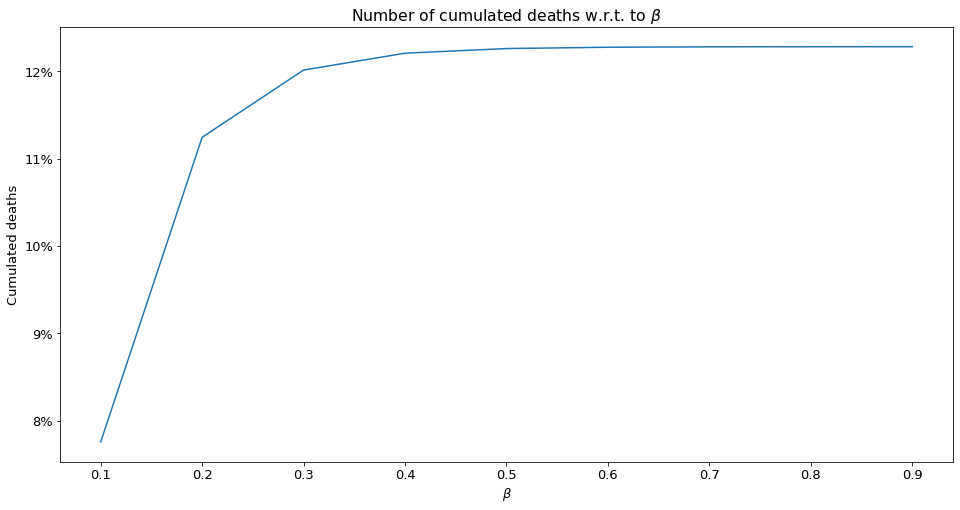

In [5]:
model.mu = 0.01
model.R_nought = 4
model.gamma = 0.04
betas = list(map(lambda x: x/10, range(1, 10, 1)))[::-1]
# f, axs = plt.subplots(1, 3, figsize=(15,7))
# i = 1
cum_deaths, beta = [], []
for infection_rate in betas:
    model.beta = infection_rate
    model.R_nought = model.beta / (model.gamma + model.mu)
    fraction_dead = model.plot_mu_bn_wrt_cd(model.R_nought, model.mu)
    cum_deaths.append(fraction_dead)
    beta.append(infection_rate)
    
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1,1,1)
plt.plot(beta, cum_deaths)
plt.title(r"Number of cumulated deaths w.r.t. to $\beta$")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
plt.xlabel(r"$\beta$")
plt.ylabel("Cumulated deaths")
plt.show("Cumulated deaths")

### <h1><center>Question 1c</center></h1>
The graph above illustrates cumulative deaths over a one year period using different values for the contact rate, meant to portray different lockdown scenarios. As these graphs show, cumulative deaths are greatest when the contact rate is largest, as a larger contact rate increases the virus's BRN, thereby increasing the extent to which it is disseminated throughout the general population. 

One obvious feature of this graph is that the cumulative deaths increase rapidly as the contact rate rises to 30%, promptly maxing out at approximately 12% thereafter. In terms of the extent of lockdown required, this graph shows it is absolutely critical to keep the beta as low as possible, and that the beneficial effects of reducing the contact raddte have are much more profound before the contact rate hits 20%. In fact, the maxing out of the cumulative death rate around 12% presumably reflects a scenario in which the population no longer has a significant amount of susceptible persons, due to immunity built-up through exposure to the virus as well as the deceased persons.

<u>Note</u>: Another potential limitation of our model is the assumption that those who were exposed to the virus and fought it off are no longer susceptible to it. Our understanding is that this assumption is true for some viruses but not others. There may also be a grey area, where previous exposure to the virus makes one less susceptible to it, without making that individual completely unsusceptible. Anything more than a cursory mention of these epidemiological factors is beyond the scope of this assignment however.

<b>Questions</b><br>
1) Should we use the same settings for gamma and mu here that we did earlier on (0.15 and 0.01)?

$R_e$ = 1 after 0 days!

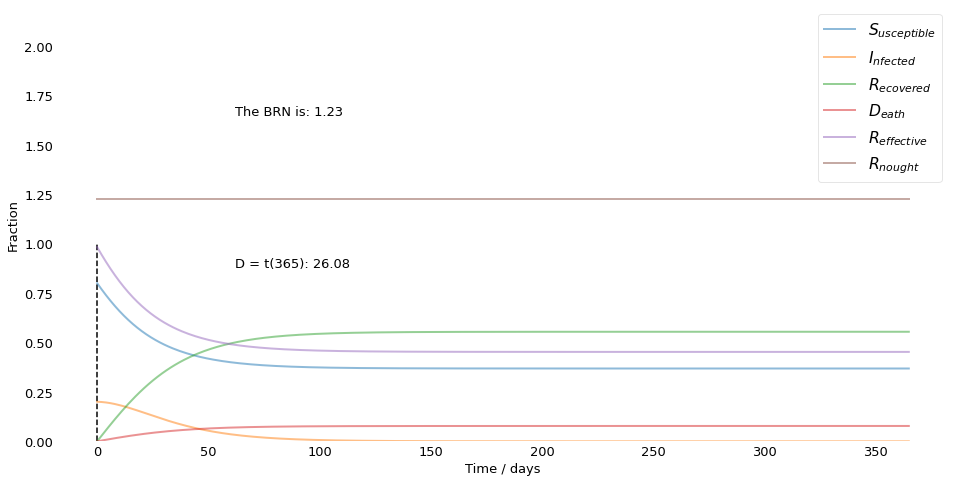

In [6]:
model.plot()

### <h1><center>Question 1b,c</center></h1>
As shown by the preceeding graph, yes it is possible to derive and plot the effective reproduction number, R, as a function of time, given otherwise fixed parameters. Indeed doing just that is the purpose of the R_effective() function defined in the SIRD class above.<br>

<b>Questions</b><br>
1) For me at least it'd be helpful to understand how the above graph works, bzw. in terms of how it plots R_effective as a function of time. <br>
2) Should we interpret the graph at all? 
